# Statistical significance of clustering results
In this notebook we study the statistical significance of our results. We will use ARI and NMI with standardized data.

## 1. Loading dataframes

In [27]:
import pandas as pd
import numpy as np
results_file = '../results/tables/clustering_L15_W3_V0e+00_ARIstd0.96_ARInorm0.96_NMIstd0.90_NMInorm0.89_04Apr2025.csv' # Adjust accordingly
df= pd.read_csv(results_file)
# extract parameters from filename
import re
match = re.search(r'L(\d+)_W(\d+)_V(\d+)', results_file)
if match:
    trunc_level = int(match.group(1))  # 15
    sig_weight = int(match.group(2))   # 2
    var_threshold = int(match.group(3))
else:
    raise ValueError("Filename format incorrect - missing L/W parameters")

print(f"trunc_level: {trunc_level}, sig_weight: {sig_weight}, var_threshold: {var_threshold}")

trunc_level: 15, sig_weight: 3, var_threshold: 0


## 2. Permutation Test

In [2]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Original unsupervised clusters (from k-means)
predicted_clusters = df['Cluster_standardized'].astype(str)

# Observed ARI (vs. true labels)
true_labels = df['Representative']  
observed_ari = adjusted_rand_score(true_labels, predicted_clusters)  
observed_nmi = normalized_mutual_info_score(true_labels, predicted_clusters)

# Permutation test
n_permutations = 1000 # Adjust if necessary
null_aris = []
null_nmis = []
for _ in range(n_permutations):
    shuffled_labels = np.random.permutation(true_labels)
    null_ari = adjusted_rand_score(shuffled_labels, predicted_clusters)
    null_aris.append(null_ari)
    null_nmi = normalized_mutual_info_score(shuffled_labels, predicted_clusters)
    null_nmis.append(null_nmi)

# Convert to NumPy arrays for vectorized comparison
null_aris = np.array(null_aris)
null_nmis = np.array(null_nmis)

#Compute p-values
p_value_ari = (np.sum(null_aris >= observed_ari) + 1) / (n_permutations + 1)
p_value_nmi = (np.sum(null_nmis >= observed_nmi) + 1) / (n_permutations + 1)
print(f"ARI p-value: {p_value_ari:.5f}")  # Expect p < 0.05 for significance
print(f"NMI p-value: {p_value_nmi:.5f}")  # Expect p < 0.05 for significance

ARI p-value: 0.00100
NMI p-value: 0.00100


### 2.1. Visualizing results

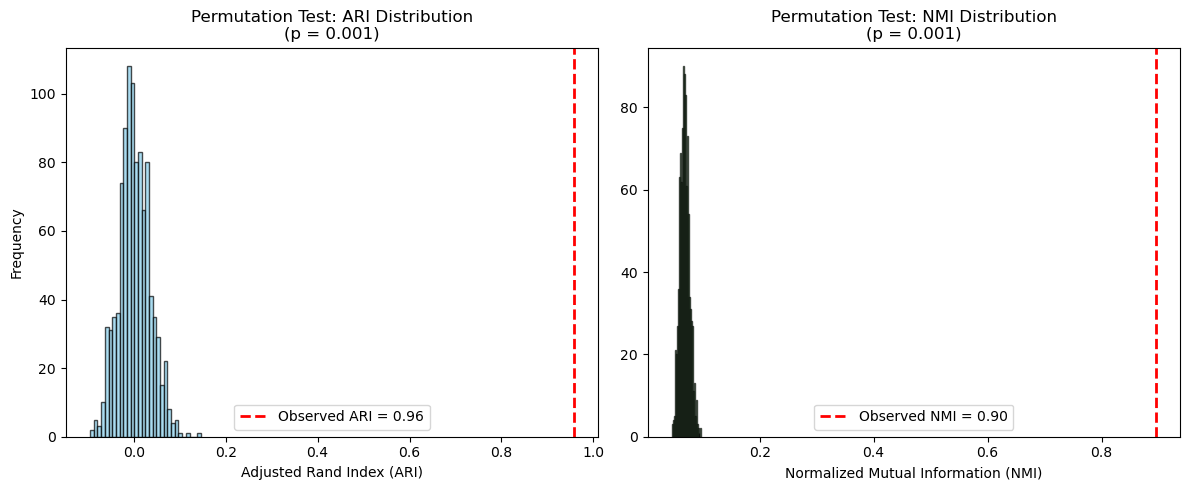

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
# Set up figure
plt.figure(figsize=(12, 5))

# Plot ARI null distribution
plt.subplot(1, 2, 1)
plt.hist(null_aris, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(observed_ari, color='red', linestyle='--', linewidth=2, label=f'Observed ARI = {observed_ari:.2f}')
plt.xlabel('Adjusted Rand Index (ARI)')
plt.ylabel('Frequency')
plt.title('Permutation Test: ARI Distribution\n(p = 0.001)')
plt.legend()

# Plot NMI null distribution
plt.subplot(1, 2, 2)
plt.hist(null_nmis, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(observed_nmi, color='red', linestyle='--', linewidth=2, label=f'Observed NMI = {observed_nmi:.2f}')
plt.xlabel('Normalized Mutual Information (NMI)')
plt.title('Permutation Test: NMI Distribution\n(p = 0.001)')
plt.legend()

plt.tight_layout()
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/perm_test_L15_W3_V0_"
    f"ARIstd{observed_ari:.2f}_"
    f"NMIstd{observed_nmi:.2f}_"
    f"{date_str}.png"
)
# plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## 3. Centroid-based permutation test using separation ratio
This test mirrors what was done in the proteins paper

We developed a permutation test to evaluate whether observed clusters exhibit statistically significant spatial separation, independent of any prior clustering algorithm (e.g., k-means). The test quantifies cluster structure using a **separation ratio**:

$$
\text{Separation Ratio} = \frac{\text{Mean distance between centroids}}{\text{Mean distance of points to their own centroid}}
$$

### Key Steps

1. **Metric Calculation**:
   - **Between-class separation**: Mean pairwise Euclidean distance between all centroids
   - **Within-class dispersion**: Mean Euclidean distance of points to their assigned centroid
   - **Observed ratio**: Higher values indicate stronger separation relative to intra-cluster compactness

2. **Null Distribution**:
   - Generated by shuffling cluster labels (1,000 permutations) while preserving data geometry
   - Computes the separation ratio for each shuffled dataset

3. **Significance Testing**:
   - The p-value is the proportion of permutations where the shuffled ratio exceeds the observed ratio (with +1 smoothing for stability)


In [9]:
# Select data corresponding to signatures
X = df.drop(columns=['Landscape', 'Chain', 'Depth', 'Length', 'N-tail', 'C-tail', 'Representative','Cluster_standardized'])
try: 
    X = X.drop(columns=['Cluster_normalized']) # remove data we kept track of in an earlier version, this is here for compatibility with that version
except Exception as e:
    print(f"Error during drop: {e}")
signatures = np.vstack(X.values)  # Shape (n_samples, n_features)
true_labels = df['Representative'].values

In [10]:
# function defining the test

import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.utils import shuffle

def separation_ratio(signatures, labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_means = np.array([signatures[labels == cls].mean(axis=0) 
                         for cls in unique_classes])
    
    # Between-class: Mean pairwise Euclidean distance between centroids
    between_dist = squareform(cdist(class_means, class_means, 'euclidean')).mean()
    
    # Within-class: Mean distance of points to their own centroid
    within_dist = np.mean([
        cdist(signatures[labels == cls], [class_means[i]], 'euclidean').mean()
        for i, cls in enumerate(unique_classes)
    ])
    
    return between_dist / within_dist

In [11]:
# Execute the test

# Observed statistic
observed_ratio = separation_ratio(signatures, true_labels)

# Permutation test
n_permutations = 1000
null_ratios = np.zeros(n_permutations)
for i in range(n_permutations):
    null_ratios[i] = separation_ratio(signatures, shuffle(true_labels))

# Significance calculation
p_value = (np.sum(null_ratios >= observed_ratio) + 1) / (n_permutations + 1)

In [12]:
print(p_value)

0.000999000999000999


### 3.1. Result visualization

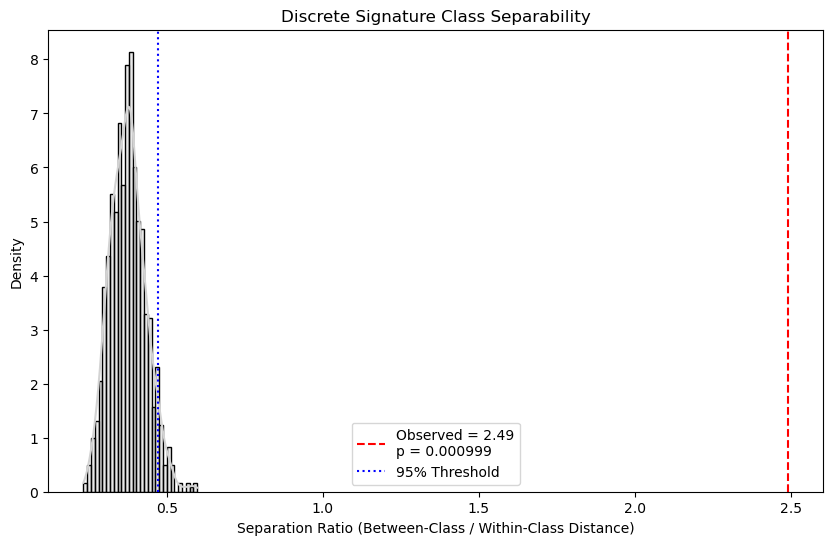

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(null_ratios, bins=30, kde=True, stat='density', 
             color='lightgray', edgecolor='k')
plt.axvline(observed_ratio, color='r', linestyle='--', 
            label=f'Observed = {observed_ratio:.2f}\np = {p_value:.6f}')
plt.axvline(np.percentile(null_ratios, 95), color='b', linestyle=':',
            label='95% Threshold')
plt.xlabel('Separation Ratio (Between-Class / Within-Class Distance)')
plt.title('Discrete Signature Class Separability')
plt.legend()
plt.show()

## 4. Centroid-based randomization test
Pairwise inter-class distance randomization test, a common method to compare whether the average signatures of specific pairs of classes are significantly different. The upper-triangular table with p-values represents the statistical significance of distances between each pair of class centroids.

In [16]:
from scipy.spatial.distance import euclidean
from itertools import combinations
from sklearn.utils import shuffle

In [17]:
# Prep our signature data
Z = df.drop(columns=['Landscape', 'Chain', 'Depth', 'Length', 'N-tail', 'C-tail', 'Representative','Cluster_standardized', 'Cluster_normalized'])
signatures = np.vstack(Z.values)  # Shape (n_samples, n_features)
true_labels = df['Representative'].values
classes = np.unique(true_labels, return_counts=False)

In [18]:
# Create a DataFrame to store p-values
p_table = pd.DataFrame(np.nan, index=classes, columns=classes, dtype=float)

Now we perform the test

In [19]:
n_permutations = 1000  # Adjust as needed

for (i, cls1), (j, cls2) in combinations(enumerate(classes), 2):
    # Get signatures for the two classes
    mask = (true_labels == cls1) | (true_labels == cls2)
    X_pair = signatures[mask]
    y_pair = true_labels[mask]
    
    # Observed distance between centroids
    centroid1 = X_pair[y_pair == cls1].mean(axis=0)
    centroid2 = X_pair[y_pair == cls2].mean(axis=0)
    obs_dist = euclidean(centroid1, centroid2)
    
    # Null distribution: shuffle labels within the pair
    null_dists = []
    for _ in range(n_permutations):
        shuffled_y = shuffle(y_pair)
        null_centroid1 = X_pair[shuffled_y == cls1].mean(axis=0)
        null_centroid2 = X_pair[shuffled_y == cls2].mean(axis=0)
        null_dists.append(euclidean(null_centroid1, null_centroid2))
    
    # Calculate p-value (one-tailed)
    null_dists = np.array(null_dists)  # Convert list to NumPy array
    p_value = (np.sum(null_dists >= obs_dist) + 1) / (n_permutations + 1)
    p_table.loc[cls1, cls2] = p_value

Visualize results in a table

In [20]:
p_table

,1fug_A,1j85_A,1uak_A,2v3j_A,3kzk_A,3znc_A,4qef_A,6qqw_A,6rqq_A
1fug_A,NaN,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
1j85_A,NaN,NaN,0.000999,0.003996,0.000999,0.000999,0.000999,0.000999,0.000999
1uak_A,NaN,NaN,NaN,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
2v3j_A,NaN,NaN,NaN,NaN,0.000999,0.000999,0.000999,0.000999,0.000999
3kzk_A,NaN,NaN,NaN,NaN,NaN,0.000999,0.000999,0.000999,0.000999
3znc_A,NaN,NaN,NaN,NaN,NaN,NaN,0.000999,0.000999,0.001998
4qef_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000999,0.000999
6qqw_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000999
6rqq_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.1. Style the table for display

In [21]:
styled_p_table = p_table.style.format({
    # 'variance_threshold': '{:.1e}',       # Scientific notation for tiny numbers
    '1fug_A': '{:.3f}',
    '1j85_A' : '{:.3f}' , '1uak_A': '{:.3f}', '2v3j_A': '{:.3f}', '3kzk_A': '{:.3f}', '3znc_A': '{:.3f}', '4qef_A': '{:.3f}',
       '6qqw_A': '{:.3f}', '6rqq_A': '{:.3f}'
}).set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([
    {  # Style for headers
        'selector': 'th',
        'props': [
            ('background-color', '#404040'),
            ('color', 'white'),
            ('width', '100px')  # Fixed width for all headers
        ]
    },
    {  # Style for data cells (to match headers)
        'selector': 'td',
        'props': [
            ('width', '100px')  # Same width as headers
        ]
    }
])

In [22]:
# 1. Clean and uppercase column names
new_columns = [col.replace('_A', '').upper() for col in p_table.columns]
p_table.columns = new_columns
p_table.index = new_columns

# 2. Style the table
styled_p_table = (
    p_table.style
    .format('{:.3f}')
    .set_properties(**{
        'border': '1px solid black',
        'text-align': 'center',
        'width': '60px',  # Reduced cell width
        'min-width': '60px',  # Ensures consistent width
        'max-width': '60px',
        'padding': '4px 8px'  # Tighter padding
    })
    .set_table_styles([
        {  # Header style
            'selector': 'th',
            'props': [
                ('background-color', '#404040'),
                ('color', 'white'),
                ('width', '60px'),
                ('text-transform', 'uppercase'),
                ('text-align', 'center'),
                ('position', 'sticky'),
                ('top', '0')
            ]
        },
        {  # Global table style
            'selector': '',
            'props': [
                ('font-family', 'Arial'),
                ('border-collapse', 'collapse'),
                ('margin', '0 auto')  # Centers table
            ]
        }
    ])
    # Gray out lower triangle + diagonal
    .map_index(
        lambda v: 'background-color: #d3d3d3; color: #d3d3d3', 
        axis=0
    )
    .map_index(
        lambda v: 'background-color: #d3d3d3; color: #d3d3d3', 
        axis=1
    )
    # Highlight significant values
    .map(lambda v: 'background-color: yellow' if isinstance(v, float) and v >= 0.001 else '')
    .map(lambda v: 'background-color: grey' if isinstance(v, float) and np.isnan(v) else '')
    # Add hover effects
    .set_table_styles([
        {
            'selector': 'td:hover',
            'props': [
                ('background-color', '#ffffa3'),
                ('font-weight', 'bold')
            ]
        }
    ], overwrite=False)
)

In [23]:
styled_p_table

,1FUG,1J85,1UAK,2V3J,3KZK,3ZNC,4QEF,6QQW,6RQQ
1FUG,nan,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1J85,nan,nan,0.001,0.004,0.001,0.001,0.001,0.001,0.001
1UAK,nan,nan,nan,0.001,0.001,0.001,0.001,0.001,0.001
2V3J,nan,nan,nan,nan,0.001,0.001,0.001,0.001,0.001
3KZK,nan,nan,nan,nan,nan,0.001,0.001,0.001,0.001
3ZNC,nan,nan,nan,nan,nan,nan,0.001,0.001,0.002
4QEF,nan,nan,nan,nan,nan,nan,nan,0.001,0.001
6QQW,nan,nan,nan,nan,nan,nan,nan,nan,0.001
6RQQ,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [28]:
# Save styled table in Excel format
table_savename= f'../results/tables/randomization_test_representative_x1_L{trunc_level}_W{sig_weight}_thresh_{var_threshold}.xlsx'
styled_p_table.to_excel(table_savename, engine='openpyxl')